In [1]:
%matplotlib inline
import numpy as np
import pickle
import re
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from setting import *
from functions import *
from xml.etree.ElementTree import Element, SubElement, dump, ElementTree, parse


In [4]:
os.chdir('D:\\Data\\VOC2007')
img_name_list=os.listdir('./JPEGImages/')

In [5]:
#Making data raw
data_raw={}
for img_name in img_name_list:
    
    #img=cv2.imread('./JPEGImages/'+img_name)
    xml_name=img_name[0:-4]+'.xml'
    annots=load_xml('./Annotations/'+xml_name)
    the_list={}
    the_list['class']=[]
    the_list['box_coords']=[]
    for j in range(len(annots[0])):
            coord=[item[j] for item in annots][:-1]
            coord=np.array(coord)
            cls=[item[j] for item in annots][-1]
            the_list['box_coords'].append(coord)
            the_list['class'].append( class_dict[cls] )
    data_raw[img_name]=the_list

In [24]:
np.save('resized_data_raw.npy',resized_data_raw)

In [3]:
#resized_dr=np.load('resized_dr.npy')
#resized_dr=resized_dr[()]
data_raw=np.load('data_raw.npy')
data_raw=data_raw[()]


In [9]:
data_raw['000001.jpg']

{'box_coords': [array([ 48, 240, 195, 371]), array([  8,  12, 352, 498])],
 'class': [4, 5]}

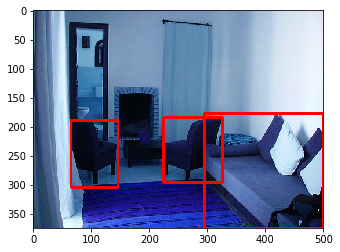

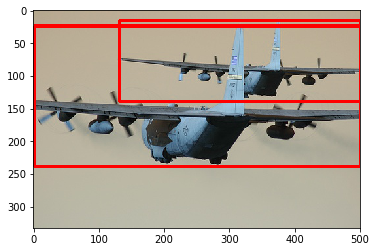

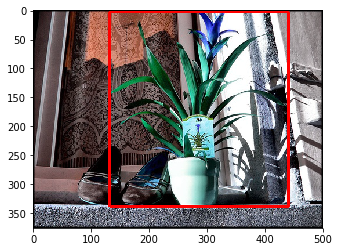

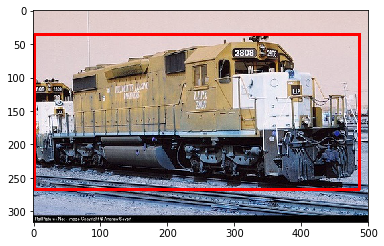

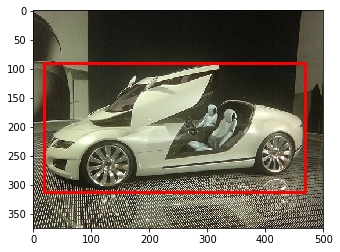

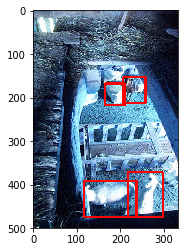

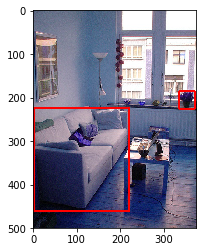

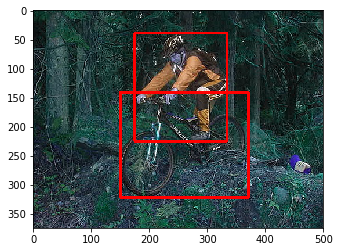

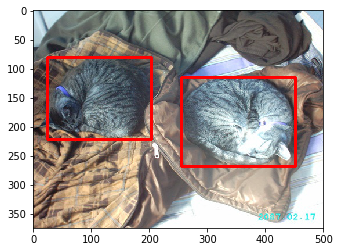

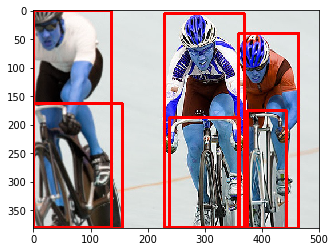

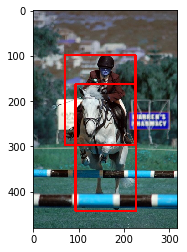

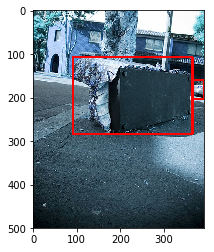

In [13]:
#Verifying Data raw

r=0
for key in data_raw.keys():
    img=cv2.imread('./JPEGImages//'+key)
    boxes=data_raw[key]['box_coords']
    for j in range(len(boxes)):
        box=boxes[j]
        box = [int(item) for item in box]
        result=cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(255,0,0),3)
    plt.figure()
    plt.imshow(result)
    
    if r > 10:
        plt.show()
        break
    r = r+1

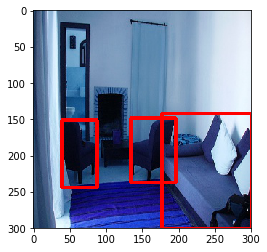

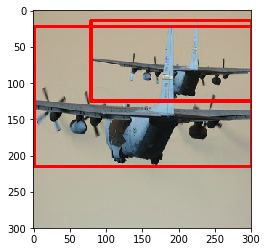

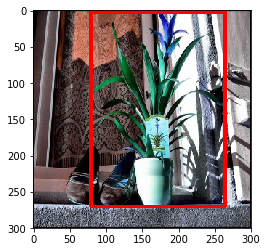

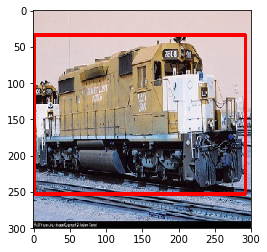

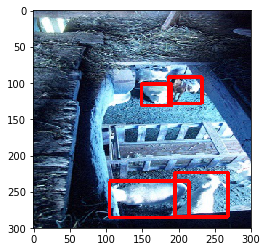

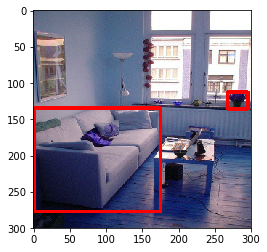

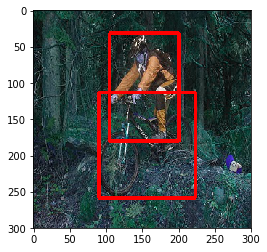

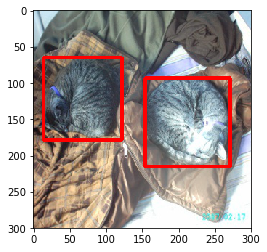

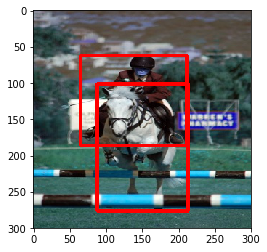

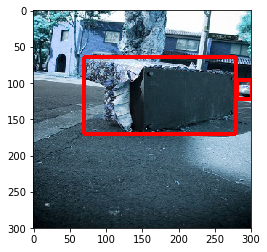

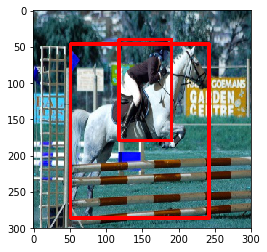

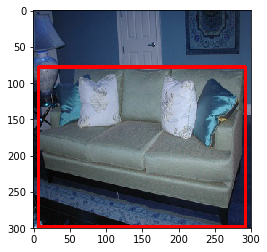

In [23]:
#Verifying resized
resized_dr = resized_data_raw
r=0
for key in resized_dr.keys():
    img=cv2.imread('./ResizedImage/'+key)
    boxes=resized_dr[key]['box_coords']
    for j in range(len(boxes)):
        box=boxes[j]
        box = [int(item) for item in box]
        result=cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(255,0,0),3)
    plt.figure()
    plt.imshow(result)
    
    if r > 10:
        plt.show()
        break
    r = r+1

In [19]:
resized_data_raw['000003.jpg']

{'box_coords': [array([  98.,   93.,  172.,  117.]),
  array([ 191.,   94.,  246.,  123.])],
 'class': [16, 2]}

In [21]:
#Making resized data_raw
del resized_data_raw
resized_data_raw={}
for key in data_raw.keys():
    
    the_list={}
    the_list['class']=[]
    the_list['box_coords']=[]
    
    img=cv2.imread('./JPEGImages/'+key)
    boxes=data_raw[key]['box_coords']
    classes=data_raw[key]['class']
    
    original_shape = img.shape
    #resized        = cv2.resize(img,(300,300))
    #cv2.imwrite('./ResizedImage/'+key , resized)
    x_ratio = 300/original_shape[1]
    y_ratio = 300/original_shape[0]
    
    
    for j in range(len(boxes)):
        box = boxes[j]
        new_coords=[box[0] * x_ratio, box[1]*y_ratio , box[2] * x_ratio , box[3] * y_ratio]
        new_coords = np.array ( [ round(item) for item in new_coords] )
        the_list['box_coords'].append(  new_coords ) 
        the_list['class'].append(classes[j])
        
    
    
    resized_data_raw[key]=the_list

In [ ]:
#Making resized data_raw
resized_data_raw={}
for key in data_raw.keys():
    
    the_list={}
    the_list['class']=[]
    the_list['box_coords']=[]
    
    img=cv2.imread('./JPEGImages/'+key)
    boxes=data_raw[key]['box_coords']
    classes=data_raw[key]['class']
    
    original_shape = img.shape
    resized        = cv2.resize(img,(300,300))
    cv2.imwrite('./ResizedImage/'+key , resized)
    x_ratio = 300/original_shape[0]
    y_ratio = 300/original_shape[1]
    
    
    for j in range(len(boxes)):
        box = boxes[j]
        new_coords=[box[0] * x_ratio, box[1]*y_ratio , box[2] * x_ratio , box[3] * y_ratio]
        new_coords = np.array ( [ round(item) for item in new_coords] )
        the_list['box_coords'].append(  new_coords ) 
        the_list['class'].append(classes[j])
        
    
    
    resized_data_raw[key]=the_list

In [ ]:
class_dict={}
for num,item in enumerate(class_list):
    class_dict[item]=num+1 #class 0 is background. 

In [10]:
data_rs=np.load('resized_data_raw.npy')
data_rs=data_rs[()]

In [4]:
def find_gt_boxes(data_raw,img_name):
    signs_class=[]
    signs_box_coords=[]
    signs_data=data_raw[img_name]
    sign_data=signs_data['class']
    if(len(signs_data['box_coords'])==0):
            return 0,0,0
    abs_box_coords = signs_data['box_coords']
    #print(signs_data['box_coords'])
    global_scale = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    
    #box_coords = np.array(abs_box_coords).astype(float) / scale
    #signs_class.append(sign_data)
    #signs_box_coords.append(box_coords)


    y_true_len=0
    for fm_size in FM_SIZES:
            y_true_len += fm_size[0] * fm_size[1] * NUM_DEFAULT_BOXES
    y_true_conf = np.zeros(y_true_len)
    y_true_loc = np.zeros(y_true_len * 4)

    match_counter=0
    #for i,gt_box_coords in enumerate(signs_box_coords):
    for j in range(len(abs_box_coords)):
        abs_box_coord=abs_box_coords[j]
        gt_box_coord = np.array(abs_box_coord).astype(float) / global_scale
        is_matched=0
        #print('abs_coord')
        #print(abs_box_coord)
        
        y_true_idx=0
        
        for fm_size in FM_SIZES:
        
            fm_h,fm_w=fm_size
            scale=np.array([fm_w,fm_h,fm_w,fm_h])
            for row in range(int(fm_h)):
                for col in range(int(fm_w)):
                    for db in DEFAULT_BOXES:
                        x1,y1,x2,y2=db
                        abs_db_box_coord=np.array([max(0,col+x1),max(0,row+y1),min(fm_w,col+x2),min(fm_h,row+y2)])
                        db_box_coord=(abs_db_box_coord.astype(float)) / scale
                        
                        iou=calc_iou(gt_box_coord,db_box_coord)
                        
                        
                        if iou>=IOU_THRESH:
                            
                            #print(signs_class)
                            y_true_conf[y_true_idx]=sign_data[j]
                            match_counter+=1
                            is_matched=1

                            abs_box_center=np.array([col+0.5,row+0.5])
                            #abs_box_center=np.array([col+1,row+1])
                            abs_gt_box_coord=gt_box_coord*scale.astype(float)
                            
                            norm_box_coord = abs_db_box_coord - np.concatenate((abs_box_center, abs_box_center))
                            y_true_loc[y_true_idx*4 : y_true_idx*4 + 4] = norm_box_coord
                           
        
                        y_true_idx+=1
            
            
        #if is_matched ==0:
        #    print('unmatched')
        #    print(abs_box_coord)
        #    print(gt_box_coord[2]-gt_box_coord[0],gt_box_coord[3]-gt_box_coord[1])
        #    print((gt_box_coord[2]-gt_box_coord[0])/(gt_box_coord[3]-gt_box_coord[1]))
    return y_true_conf,y_true_loc,match_counter

In [5]:
def find_gt_boxes_allone(data_raw,img_name,idx,idx_db,pick_one=False):
    signs_class=[]
    signs_box_coords=[]
    signs_data=data_raw[img_name]
    sign_data=signs_data['class']
    abs_box_coords = signs_data['box_coords']

    global_scale = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    y_true_len=0
    for fm_size in FM_SIZES:
            y_true_len += fm_size[0] * fm_size[1] * len(DEFAULT_BOXES)
    y_true_conf = np.zeros(y_true_len)
    y_true_loc = np.zeros(y_true_len * 4)

    
    
 
    y_true_idx=0
    for k in range(len(FM_SIZES)):
        fm_size = FM_SIZES[k]
        

        fm_h,fm_w=fm_size
        scale=np.array([fm_w,fm_h,fm_w,fm_h])
        for row in range(int(fm_h)):
            for col in range(int(fm_w)):
                for j in range(len(DEFAULT_BOXES)):
                    if not k ==idx:
                        y_true_idx+=1
                        continue
                    if idx_db > 0:
                        if not j ==idx_db:
                            y_true_idx+=1
                            continue    
                    x1,y1,x2,y2=DEFAULT_BOXES[j]
                    abs_db_box_coord=np.array([max(0,col+x1),max(0,row+y1),min(fm_w,col+x2),min(fm_h,row+y2)])

                    y_true_conf[y_true_idx]=1
                    abs_box_center=np.array([col+0.5,row+0.5])

                    norm_box_coord = abs_db_box_coord - np.concatenate((abs_box_center, abs_box_center))
                    y_true_loc[y_true_idx*4 : y_true_idx*4 + 4] = norm_box_coord

                    y_true_idx+=1
                    if pick_one:
                        return y_true_conf,y_true_loc
    return y_true_conf,y_true_loc

In [12]:

data_prep = {}
c=1
for img_name in data_rs.keys():
    y_true_conf, y_true_loc, match_counter=find_gt_boxes(data_rs,img_name)
    if match_counter==0:
        print(img_name)
        continue
    if match_counter > 0:
        data_prep[img_name] = {'y_true_conf': y_true_conf, 'y_true_loc': y_true_loc}
    #print(match_counter)
    c+=1
    if c%100==0:
        np.save(str(c)+'_data_prep.npy',data_prep)
        del data_prep
        data_prep = {}
    if c>100:
        break
np.save(str(c)+'_data_prep.npy',data_prep)
del data_prep

003438.jpg
004670.jpg
004070.jpg
001705.jpg
000087.jpg
000136.jpg
004161.jpg
005709.jpg
002357.jpg
005324.jpg
003427.jpg
000195.jpg
001339.jpg
004107.jpg
009220.jpg
009675.jpg
003816.jpg
005164.jpg
004324.jpg
009594.jpg
004151.jpg
000600.jpg
007304.jpg
008432.jpg
001389.jpg
004572.jpg
007716.jpg
000062.jpg
003411.jpg
005562.jpg
007922.jpg


In [6]:
IOU_THRESH = 0.55

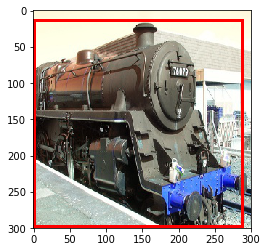

In [12]:
img=cv2.imread('./ResizedImage/'+img_name)
boxes=data_rs[img_name]['box_coords']
for j in range(len(boxes)):
    box=boxes[j]
    box = [int(item) for item in box]
    result=cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(255,0,0),3)
plt.figure()
plt.imshow(result)
plt.show()

In [7]:
data_rs =data_raw

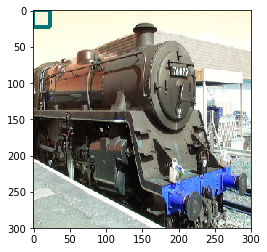

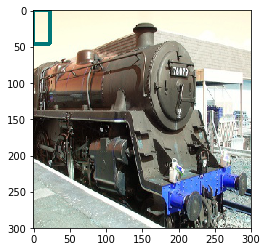

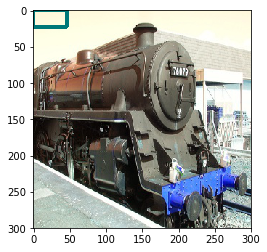

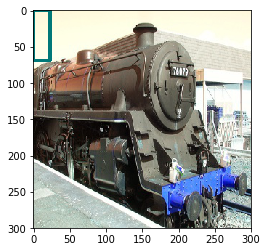

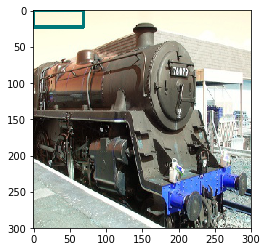

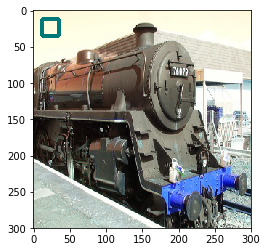

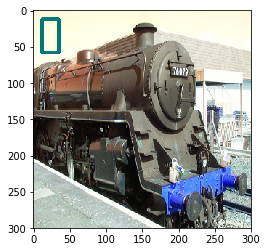

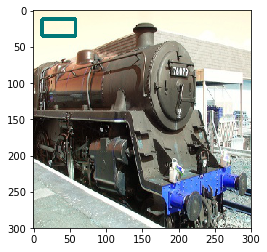

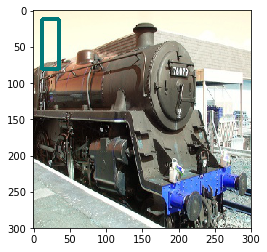

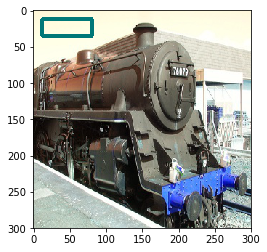

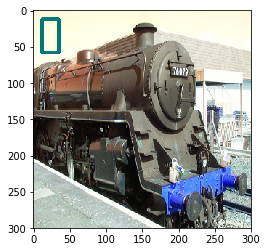

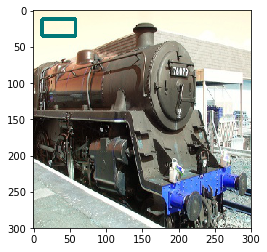

In [17]:
img_name='005689.jpg'
for j in range(12):
    y_true_conf, y_true_loc=find_gt_boxes_allone(data_rs,img_name,1,j,pick_one=True)
    yt_confs=np.array(y_true_conf)
    yt_locs=np.array(y_true_loc)
    boxes=nms_gt(yt_confs,yt_locs)
    image=cv2.imread('./ResizedImage//'+img_name)
    for j in range(len(boxes)):
            box=boxes[j][0]
            result=cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,120,120),3)
    plt.figure()
    plt.imshow(result)
plt.show()

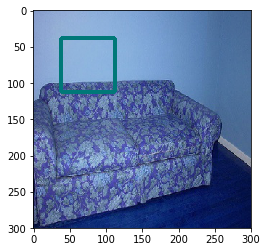

In [43]:
img_name='004838.jpg'
y_true_conf, y_true_loc=find_gt_boxes_allone(data_rs,img_name,3,7,pick_one=True)
yt_confs=np.array(y_true_conf)
yt_locs=np.array(y_true_loc)
boxes=nms_gt(yt_confs,yt_locs)
image=cv2.imread('./ResizedImage//'+img_name)
for j in range(len(boxes)):
        box=boxes[j][0]
        result=cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,120,120),3)
plt.figure()
plt.imshow(result)
plt.show()

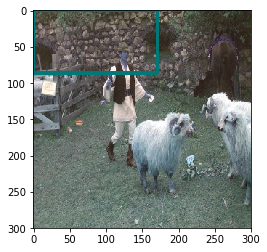

In [107]:
y_true_conf, y_true_loc, match_counter=find_gt_boxes_allone(data_rs,img_name,3,2,pick_one=True)
yt_confs=np.array(y_true_conf)
yt_locs=np.array(y_true_loc)
boxes=nms_gt(yt_confs,yt_locs)
image=cv2.imread('./ResizedImage//'+img_name)
for j in range(len(boxes)):
        box=boxes[j][0]
        result=cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,120,120),3)
plt.figure()
plt.imshow(result)
plt.show()

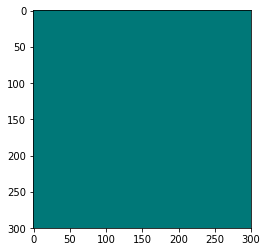

In [74]:
y_true_conf, y_true_loc, match_counter=find_gt_boxes_allone(data_rs,img_name,1)
yt_confs=np.array(y_true_conf)
yt_locs=np.array(y_true_loc)
boxes=nms_gt(yt_confs,yt_locs)
image=cv2.imread('./ResizedImage//'+img_name)
for j in range(len(boxes)):
        box=boxes[j][0]
        result=cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,120,120),3)
plt.figure()
plt.imshow(result)
plt.show()

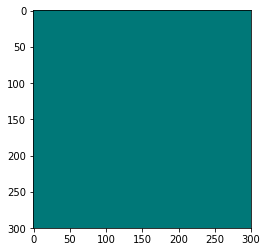

In [75]:
y_true_conf, y_true_loc, match_counter=find_gt_boxes_allone(data_rs,img_name,0)
yt_confs=np.array(y_true_conf)
yt_locs=np.array(y_true_loc)
boxes=nms_gt(yt_confs,yt_locs)
image=cv2.imread('./ResizedImage//'+img_name)
for j in range(len(boxes)):
        box=boxes[j][0]
        result=cv2.rectangle(image,(box[0],box[1]),(box[2],box[3]),(0,120,120),3)
plt.figure()
plt.imshow(result)
plt.show()

In [42]:
DEFAULT_BOXES = ((0,0,1,1),(0,0,1,2),(0,0,2,1),(0,0,1,3),
                 (0,0,3,1),(0.5,0.5,1.5,1.5),(0.5,0.5,1.5,2.5),(0.5,0.5,2.5,1.5),
                 (0.5,0.5,1.5,3.5),(0.5,0.5,3.5,1.5))

In [6]:
FM_SIZES

[[25, 25], [13, 13], [7, 7], [4, 4]]

In [7]:
IOU_THRESH = 0.50

In [10]:
np.save('dp.npy',data_prep)